# LowHighRegression from Level2 experiments


To install conda and binance packages to this notebook uncomment the code below

In [1]:
#%%capture
#%conda install -c plotly plotly=5.9.0
#%conda install pip
#%conda install twisted
# %pip install plotly==5.9.0
# %pip install twisted
# %pip install binance-connector==1.13.0
# %pip install pandas
#%pip install scikit-learn==1.5.1
#%pip install tensorflow==2.16.1
#%pip install keras==3.3.3
#%pip install keras==2.11.0
#%pip install scrapy==2.11.2
#%pip install itemloaders==1.2.0
# %pip install keras
# %pip install scikeras
# %pip install keras-tuner
# %pip install boto3
#%pip install python-dotenv
#%pip install prophet

import os
import sys

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
sys.path.append("pytrade2/pytrade2")
# Read .env variable with s3 access keys
#%load_ext dotenv
#%dotenv

## App parameters

In [2]:
# env file
#env_file='local.env'
env_file='local.env'
from dotenv import load_dotenv
dotenv_path = os.path.abspath(env_file) #travels up a level to find the .env
load_dotenv(dotenv_path)

ticker="BTC-USDT"
# Preprocess raw data
data_dir_root = "./data"
data_dir_raw = f"{data_dir_root}/raw"
data_dir_preproc = f"{data_dir_root}/preproc"

#history_days = 100
history_days=15
#history_days=720

# Current params: profit/dropdown = 23.18, mean 125, median = 207
# Features: how much candles of each period to include
#features_candles_periods = ['30min', '40min', '43min', '44min','45min', '46min', '47min', '50min', '60min', '90min', '120min']
#target_period='45min'

# features_candles_periods = ['30min', '40min', '43min', '44min','45min', '46min', '47min', '50min', '60min', '90min', '120min']
# target_period='45min'


features_candles_periods = ["15min", "30min", "60min"]
target_period = '60min'

profit_loss_ratio = 2

#test_days = 15
test_days = 3

take_profit_min_coeff = 0.0012
stop_loss_max_coeff = 0.0048
# 0.001 = 60 for price=60K
#stop_loss_add_ratio = 0.0002
stop_loss_add_ratio = 0.001
#take_profit_max_coeff = 0.005
take_profit_max_coeff = 0.005 # 600
stop_loss_min_coeff = 0.00012
comission_pct = 0.012
price_precision = 2
is_trailing_stop = False
comission = 0.01 * comission_pct
#lgb_params = {'learning_rate':0.1, 'num_iterations': 100}
lgb_params = {'learning_rate':0.1, 'num_iterations': 100}


# lgb_params = {
#         #"n_estimators": 1000,
#         # "max_depth": 6,
#         # "min_samples_split": 10,
#         # "min_samples_leaf": 4,
#         # "bootstrap": True,
#         # "oob_score": False,
#         # "random_state": 888,
    
#     'learning_rate':0.1, 'num_iterations': 150}


experiment_name = 'LowHighRegression'
run_name =  f'LHR target: {target_period}, sharp: {profit_loss_ratio}, periods:{features_candles_periods},  history {history_days}, test {test_days}'
do_log_experiment = False
do_log_model = False
is_trade_ready = False



In [3]:
# Indicators' params for each candle period
features_params = {
    "5min":
        {
            "cca": {"window": 20},
            "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
            "adx": {"window": 14},
            "rsi": {"window": 14},
            "stoch": {"window": 14, "smooth_window": 3},
            "macd": {"slow": 26, "fast": 12}
        },
    "10min":
        {
            "cca": {"window": 20},
            "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
            "adx": {"window": 14},
            "rsi": {"window": 14},
            "stoch": {"window": 14, "smooth_window": 3},
            "macd": {"slow": 26, "fast": 12}
        },
    "20min":
        {
            "cca": {"window": 20},
            "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
            "adx": {"window": 14},
            "rsi": {"window": 14},
            "stoch": {"window": 14, "smooth_window": 3},
            "macd": {"slow": 26, "fast": 12}
        },
    "30min":
        {
            "cca": {"window": 20},
            "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
            "adx": {"window": 14},
            "rsi": {"window": 14},
            "stoch": {"window": 14, "smooth_window": 3},
            "macd": {"slow": 26, "fast": 12}
        },
    "40min":
        {
            "cca": {"window": 20},
            "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
            "adx": {"window": 14},
            "rsi": {"window": 14},
            "stoch": {"window": 14, "smooth_window": 3},
            "macd": {"slow": 26, "fast": 12}
        },
}
# Default
#features_params = None
features_params = {
    "45min":
        {
            "cca": {"window": 20},
            "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
            "adx": {"window": 14},
            "rsi": {"window": 14},
            "stoch": {"window": 14, "smooth_window": 3},
            "macd": {"slow": 26, "fast": 12}
        }
}

## Feature engineering
Read data from bot's history, resample to equal intervals, create X, y

### Read level2, bid/ask, candles data from history

### Preprocess data if configured

In [4]:
import pathlib

from features.level2.Level2Features import Level2Features
import numpy as np

def level2_transform(df_level2_raw):
    # from features.level2.Level2Buckets import Level2Buckets
    # df_level2_buckets = Level2Buckets().level2_buckets(df_level2_raw, "60s")
    # df_level2_buckets.tail()
    df_level2 = Level2Features().expectation(df_level2_raw)
    #df_level2_features = df_level2_features.rolling("1min").agg("mean")
    df_level2["l2_bid_ask_vol"] = df_level2["l2_bid_vol"] + df_level2["l2_ask_vol"]
    df_level2 = df_level2[["l2_bid_expect", "l2_bid_vol","l2_ask_expect", "l2_ask_vol", "l2_bid_ask_vol"]]
    return df_level2

def get_unprocessed_raw_files(kind):
    """ 
    Compare raw files dir with preprocessed dir, get not processed raw files 
    Raw files have .csv.zip extension, processed are with .csv
    """
    
    raw_files = sorted(os.listdir(os.path.join(data_dir_raw, kind)))
    if not raw_files: 
        return []

    # Get all raw and preprocessed files
    raw_files_wo_zip = sorted([pathlib.Path(raw_file).stem for raw_file in raw_files])
    preproc_files = sorted(os.listdir(os.path.join(data_dir_preproc, kind)))

    # Compare raw with preprocessed, create unprocessed list, redo last preprocessed (it could be not full previously)
    last_processed_raw_file = f"{preproc_files[-1]}.zip"
    last_raw_file = f"{raw_files[-1]}"
    if last_raw_file == last_processed_raw_file:
        print(f"No new raw data appeared after {last_raw_file}")
        return []
    
    files_unprocessed_wo_zip = set(raw_files_wo_zip) - set(preproc_files)
    raw_files_unprocessed = sorted([f"{f}.zip" for f in files_unprocessed_wo_zip] + [last_processed_raw_file])

    return raw_files_unprocessed

def preprocess_last_raw_data(ticker:str, kind:str, days:int = 1, datetime_col: str = "datetime", agg = "mean", transform_func = None):
    """ Read raw data resampled to 1 min. Needed to reduce data amount"""
    source_dir = f"{data_dir_raw}/{kind}"
    print(f"Read new {ticker} {kind} data from {source_dir}")
    target_dir = f"{data_dir_preproc}/{kind}"
    # file_paths = sorted(
    #     [f"{source_dir}/{f}" for f in os.listdir(source_dir)])[-days:]
    
    unprocessed_raw_files = get_unprocessed_raw_files(kind)
    file_paths =  [f"{source_dir}/{f}" for f in unprocessed_raw_files]
    print(f"Preprocess {len(file_paths)} new {kind} raw files")
    for raw_file_path in file_paths:
        print(f"Read {ticker} {kind} data from {raw_file_path}")
        # Read raw data
        df = pd.read_csv(raw_file_path, parse_dates = True)
        df[datetime_col] = pd.to_datetime(df[datetime_col])
        df.set_index(datetime_col, drop = False, inplace = True)

        # Transform to features if needed
        if transform_func:
            df = transform_func(df)

        #Drop duplicate datetime column
        drop_cols = ["datetime", f"{datetime_col}.1", "ticker", "symbol"]
        for drop_col in drop_cols:
            if drop_col in df.columns:
                del df[drop_col]        

        df = df.resample("1min", label = "right", closed = "right").agg(agg)
        
        # Prepare target path
        target_file_name = pathlib.Path(raw_file_path).stem
        if not target_file_name.endswith("csv"): target_file_name += ".csv"
        preprocessed_file_path = os.path.join(target_dir, target_file_name)

        # Write
        print(f"Write {ticker} {kind} data to {preprocessed_file_path}")
        df.to_csv(preprocessed_file_path, header = True)


preprocess_last_raw_data(ticker, kind = "level2", days = history_days, transform_func = level2_transform)
preprocess_last_raw_data(ticker, kind = "bid_ask", days = history_days)
preprocess_last_raw_data(ticker, kind = "candles", days = history_days, datetime_col = "close_time", agg = {"open_time" : "last", "close_time": "last", "open": "first", "high": "max", "low": "min", "close": "last", "vol": "sum"})


Read new BTC-USDT level2 data from ./data/raw/level2
No new raw data appeared after 2025-04-15_BTC-USDT_level2.csv.zip
Preprocess 0 new level2 raw files
Read new BTC-USDT bid_ask data from ./data/raw/bid_ask
No new raw data appeared after 2025-04-15_BTC-USDT_bid_ask.csv.zip
Preprocess 0 new bid_ask raw files
Read new BTC-USDT candles data from ./data/raw/candles
No new raw data appeared after 2025-04-15_BTC-USDT_candles.csv.zip
Preprocess 0 new candles raw files


### Read preprocessed bid/ask, level2, candles

In [5]:
from tools.DataTool import DataTool
from strategy.persist.DataPersister import DataPersister
import os
import shutil
import numpy as np


def read_last_preproc_data(kind:str, days=1, datetime_col = "datetime"):
    """ Read last given days from preprocessed directory """
    
    source_dir = f"{data_dir_preproc}/{kind}"
    print(f"Read {ticker} {kind} data for {days} days from {source_dir}")

    file_paths = sorted(
        [f"{source_dir}/{f}" for f in os.listdir(source_dir)])[-days:]
    
    df = pd.concat([pd.read_csv(f, parse_dates=True) for f in file_paths])
    df = clean_columns(df, datetime_col)
    return df
    
def clean_columns(df: pd.DataFrame, datetime_col: str = "datetime"):
    """ After level2, bidask or candles df has been read, set datetime index, clean columns which are not needed"""
    remove_cols = [f"{datetime_col}.1","ticker", "symbol"]
    for remove_col in remove_cols:
        if remove_col in df.columns:
            del df[remove_col]
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df.set_index(datetime_col, drop = False, inplace = True)
    return df

#df_bid_ask = read_last_preproc_data("bid_ask", days = history_days)
#df_candles = read_last_preproc_data("candles", days = history_days, datetime_col = "close_time")
#df_level2 = read_last_preproc_data("level2", days = history_days)

In [6]:
df_bid_ask = read_last_preproc_data("bid_ask", days = history_days)
df_bid_ask.tail()

Read BTC-USDT bid_ask data for 15 days from ./data/preproc/bid_ask


datetime           bid      bid_vol           ask      ask_vol
datetime                                                                                     
2025-04-15 06:06:00 2025-04-15 06:06:00  85520.862109  2708.313119  85521.085335  1033.421720
2025-04-15 06:07:00 2025-04-15 06:07:00  85611.626153  3116.636328  85611.862560  1255.802862
2025-04-15 06:08:00 2025-04-15 06:08:00  85614.122146  3383.037165  85614.282605  1492.599617
2025-04-15 06:09:00 2025-04-15 06:09:00  85600.460736  1292.243798  85600.640462  2952.628743
2025-04-15 06:10:00 2025-04-15 06:10:00  85533.747317  1395.821550  85534.056346  2547.101363

In [7]:
df_candles_1min = read_last_preproc_data("candles", datetime_col = "close_time", days = history_days)
df_candles_1min.tail()

Read BTC-USDT candles data for 15 days from ./data/preproc/candles


close_time            open_time     open     high      low    close     vol
close_time                                                                                              
2025-04-15 06:05:00 2025-04-15 06:05:00  2025-04-15 06:04:00  85459.7  85561.4  85459.6  85561.4  121274
2025-04-15 06:06:00 2025-04-15 06:06:00  2025-04-15 06:05:00  85561.4  85642.7  85561.4  85621.9   40126
2025-04-15 06:07:00 2025-04-15 06:07:00  2025-04-15 06:06:00  85621.9  85634.8  85589.2  85634.7   40146
2025-04-15 06:08:00 2025-04-15 06:08:00  2025-04-15 06:07:00  85634.7  85634.8  85568.2  85569.4  122224
2025-04-15 06:09:00 2025-04-15 06:09:00  2025-04-15 06:08:00  85569.4  85576.4  85481.2  85481.2   68706

In [8]:
df_level2 = read_last_preproc_data("level2", days = history_days)
df_level2.tail()

Read BTC-USDT level2 data for 15 days from ./data/preproc/level2


datetime  l2_bid_expect     l2_bid_vol  l2_ask_expect     l2_ask_vol  l2_bid_ask_vol
datetime                                                                                                           
2025-04-15 06:06:00 2025-04-15 06:06:00   85426.038549  201518.315609   85633.560336  155760.646655   357278.962264
2025-04-15 06:07:00 2025-04-15 06:07:00   85517.791289  199217.263339   85723.438417  149079.874355   348297.137694
2025-04-15 06:08:00 2025-04-15 06:08:00   85519.360385  194545.884483   85717.984035  146391.603448   340937.487931
2025-04-15 06:09:00 2025-04-15 06:09:00   85486.392634  182412.402754   85686.884454  156920.609294   339333.012048
2025-04-15 06:10:00 2025-04-15 06:10:00   85430.720846  178955.087452   85634.796299  154816.522814   333771.610266

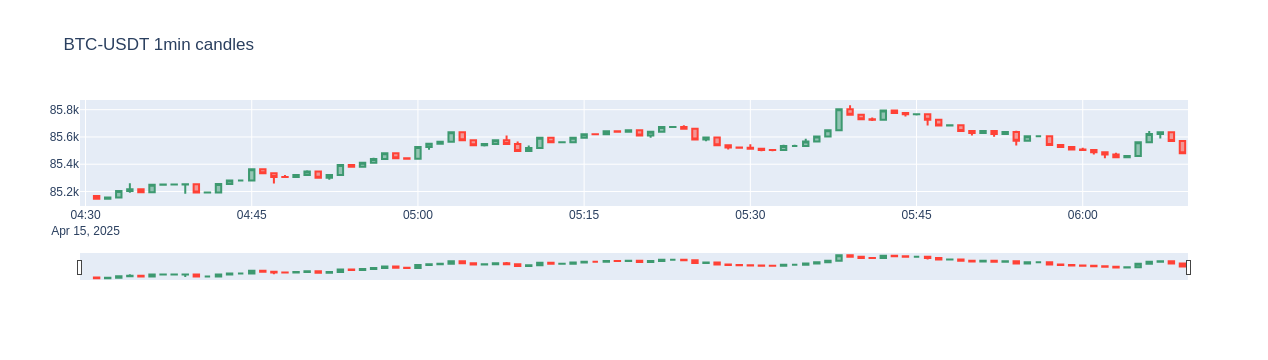

In [9]:
from tools.PlotTool import PlotTool
df_candles_1min["ticker"] = ticker
PlotTool.plot_candles(df_candles_1min.tail(100), '1min')

In [10]:
def level2_features_of(df_level2):
    features = df_level2.copy()
    del features["datetime"]
    features = features.diff().add_suffix("_diff")
    return features

### Build features and targets

In [11]:
sys.path.append("pytrade2/pytrade2")
from pytrade2.pytrade2.features.CandlesFeatures import CandlesFeatures
from pytrade2.pytrade2.features.MultiIndiFeatures import MultiIndiFeatures
from pytrade2.pytrade2.features.LowHighTargets import LowHighTargets
 
# Candles by periods dictionary
candles_by_period = DataTool.candles_by_periods_of(df_candles_1min, features_candles_periods)
#print('Candles counts: %s' % {period: len(df) for period, df in candles_by_period.items()})

# Features
candles_features = MultiIndiFeatures.multi_indi_features(candles_by_period, features_params)
level2_features = level2_features_of(df_level2)
features = pd.merge_asof(candles_features, level2_features, left_index = True, right_index=True)


targets = LowHighTargets.fut_lohi(candles_by_period[target_period], target_period)
features = features.dropna()
targets = targets.dropna()
features = features[features.index.isin(targets.index)]
targets = targets[targets.index.isin(features.index)]
features.tail()
#targets.tail(100)
#targets.info()
#targets[targets.isna()].tail()

time_hour  time_minute  ichimoku_base_line_15min_diff  ichimoku_conversion_line_15min_diff  ichimoku_a_15min_diff  ichimoku_b_15min_diff  cci_15min_diff  adx_15min_diff  rsi_15min_diff  stoch_15min_diff  macd_15min_diff  ichimoku_base_line_30min_diff  ichimoku_conversion_line_30min_diff  ichimoku_a_30min_diff  ichimoku_b_30min_diff  cci_30min_diff  adx_30min_diff  rsi_30min_diff  stoch_30min_diff  macd_30min_diff  ichimoku_base_line_60min_diff  ichimoku_conversion_line_60min_diff  ichimoku_a_60min_diff  ichimoku_b_60min_diff  cci_60min_diff  adx_60min_diff  rsi_60min_diff  stoch_60min_diff  macd_60min_diff  l2_bid_expect_diff  l2_bid_vol_diff  l2_ask_expect_diff  l2_ask_vol_diff  l2_bid_ask_vol_diff
close_time                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2025-04-15 01:00:00          1            0                            0.0                               -116.0                  -58.0                    0.0        1.292131        0.453277        0.817816          2.560884        -0.388099                            0.0                                  0.0                    0.0                    0.0         3.25917        0.165284       -1.225593         -4.131964       -25.163333                            0.0                                  0.0                    0.0                    0.0       -5.954553       -0.933615       -1.104677         -3.661272       -59.621029           33.934029     10300.311106           40.157394    -11589.339173         -1289.028067
2025-04-15 02:00:00          2            0                            0.0                               -116.0                  -58.0                    0.0        1.292131        0.453277        0.817816          2.560884        -0.388099                            0.0                                  0.0                    0.0                    0.0         3.25917        0.165284       -1.225593         -4.131964       -25.163333                            0.0                                  0.0                    0.0                    0.0       -5.954553       -0.933615       -1.104677         -3.661272       -59.621029          -23.449017     -9207.070848          -31.270521       601.106807         -8605.964041
2025-04-15 03:00:00          3            0                            0.0                               -116.0                  -58.0                    0.0        1.292131        0.453277        0.817816          2.560884        -0.388099                            0.0                                  0.0                    0.0                    0.0         3.25917        0.165284       -1.225593         -4.131964       -25.163333                            0.0                                  0.0                    0.0                    0.0       -5.954553       -0.933615       -1.104677         -3.661272       -59.621029          122.780509     -1354.275459          126.732228     -7224.762938         -8579.038397
2025-04-15 04:00:00          4            0                            0.0                               -116.0                  -58.0                    0.0        1.292131        0.453277        0.817816          2.560884        -0.388099                            0.0                                  0.0                    0.0                    0.0         3.25917 

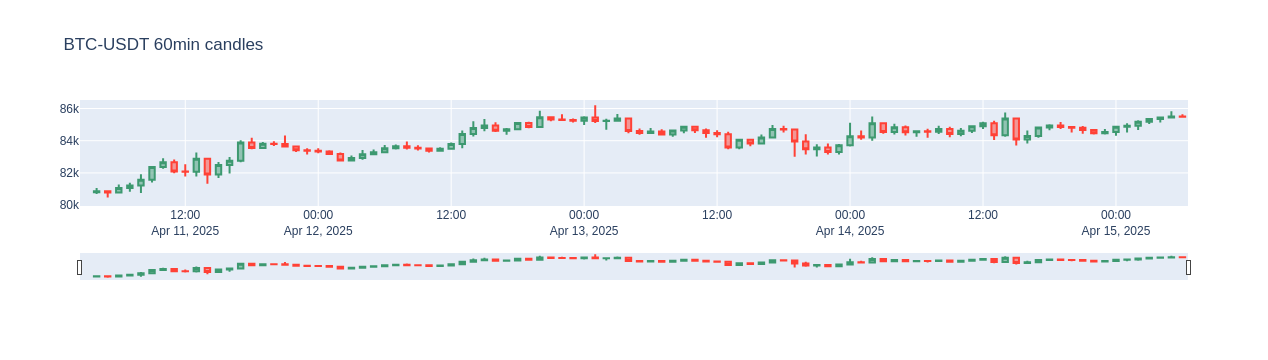

In [12]:
#PlotTool.plot_candles(candles_by_period['10min'].tail(100), target_period)
PlotTool.plot_candles(candles_by_period[target_period].tail(100), target_period, ticker)
#candles_by_period[target_period].tail()


### Train test split

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler

def create_pipe(x, y) -> (Pipeline, Pipeline):
    """ Create feature and target pipelines to use for transform and inverse transform """

    time_cols = [col for col in x.columns if col.startswith("time")]
    float_cols = list(set(x.columns) - set(time_cols))
    x_pipe = Pipeline(
        [("xscaler", ColumnTransformer([("xrs", StandardScaler(), float_cols)], remainder="passthrough")),
         ("xmms", MaxAbsScaler())])
    x_pipe.fit(x)

    y_pipe = Pipeline(
        [("yrs", StandardScaler()),
         ("ymms", MaxAbsScaler())])
    y_pipe.fit(y)
    return x_pipe, y_pipe


In [14]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer, make_column_selector
import matplotlib.pyplot as plt

def train_test_split(x, y, test_days=14):
    """ In addition to train_test_split, create pipeline for reverse transform in future"""
    #test_index = int(len(x)*(1-test_size))
    print(x.info())
    test_index = max(x.index) - pd.Timedelta(days=test_days)
    is_test = (x.index >= test_index)
    is_train = (x.index < test_index)
    
    x_train, y_train, x_test, y_test = x[is_train], y[is_train], \
        x[is_test], y[is_test]
    
    #test_index = int(len(x)*(1-test_size))

    # Split df to train/test
    # x_train, y_train, x_test, y_test = x.iloc[:test_index], y.iloc[:test_index], \
    #     x.iloc[test_index:], y.iloc[test_index:]

    # Create pipeline to transform/reverse transform
    x_pipe, y_pipe = create_pipe(x_train, y_train)
    return x_pipe, y_pipe, x_train, y_train, x_test, y_test


x_pipe, y_pipe, x_train, y_train, x_test, y_test = train_test_split(features, targets, test_days=test_days)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 290 entries, 2025-04-02 00:00:00 to 2025-04-15 05:00:00
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   time_hour                            290 non-null    int32  
 1   time_minute                          290 non-null    int32  
 2   ichimoku_base_line_15min_diff        290 non-null    float64
 3   ichimoku_conversion_line_15min_diff  290 non-null    float64
 4   ichimoku_a_15min_diff                290 non-null    float64
 5   ichimoku_b_15min_diff                290 non-null    float64
 6   cci_15min_diff                       290 non-null    float64
 7   adx_15min_diff                       290 non-null    float64
 8   rsi_15min_diff                       290 non-null    float64
 9   stoch_15min_diff                     290 non-null    float64
 10  macd_15min_diff                      290 non-null    float64


## Model creation and training

### Create model

In [15]:
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from keras import Sequential, Input
from keras.layers import Dense, Dropout
from sklearn.linear_model import LinearRegression

model_name='MultiOutputRegressorLgb'
import mlflow
from mlflow import MlflowClient

#mlflow.set_tracking_uri('http://localhost:5000')
mlflow_client = MlflowClient()

def create_model_linreg():
    
    model = LinearRegression()
    model = MultiOutputRegressor(model)
    print(f'Created new model {model}')
    return model

def create_model_keras(X_size, y_size):
    model = Sequential()
    model.add(Input(shape=(X_size,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(y_size, activation='linear'))
    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error'])

    # Load weights
    #self.model_persister.load_last_model(model)
    model.summary()
    return model


def create_model_lgb(lgb_params):
    """ MultiOutputRegressor with lgb model. """
    lgb_model =  lgb.LGBMRegressor(**lgb_params)
    model = MultiOutputRegressor(lgb_model)
    print(f'Created new model {model}')
    return model

def ensure_model(model_name):
    versions = mlflow_client.search_model_versions(f"name='{model_name}'")

    if versions:
        version = versions[-1]
        model = mlflow.sklearn.load_model(versions[-1].source)
        model_url = f'models:/{model_name}/{version.version}'
    else:
        model = create_model()
        model_url = None
    return model, model_url

#model, model_url = ensure_model(model_name)
#print(model_url)
#model = create_model(len(features.columns), len(targets.columns))
model = create_model_lgb(lgb_params)


2025-04-15 12:14:06.470926: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-15 12:14:07.232331: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Created new model MultiOutputRegressor(estimator=LGBMRegressor(num_iterations=100))


### Fit, predict

In [16]:
model.fit(x_pipe.transform(x_train), y_pipe.transform(y_train))

# Predict and inverse transform to dataframe
y_pred = model.predict(x_pipe.transform(x_test))
y_pred = y_pipe.inverse_transform(y_pred)
y_pred = pd.DataFrame(y_pred, columns = y_test.columns, index = y_test.index)
y_pred.tail()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 394
[LightGBM] [Info] Number of data points in the train set: 217, number of used features: 6
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/home/dima/.local/lib/python3.12/site-packages/lightgbm/engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/dima/.local/lib/python3.12/site-packages/lightgbm/engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



fut_low_diff  fut_high_diff
close_time                                      
2025-04-15 01:00:00   -537.921786     531.419589
2025-04-15 02:00:00   -261.986352     518.015421
2025-04-15 03:00:00   -240.223863     620.658330
2025-04-15 04:00:00   -308.888343     141.465200
2025-04-15 05:00:00   -349.197443     250.913982

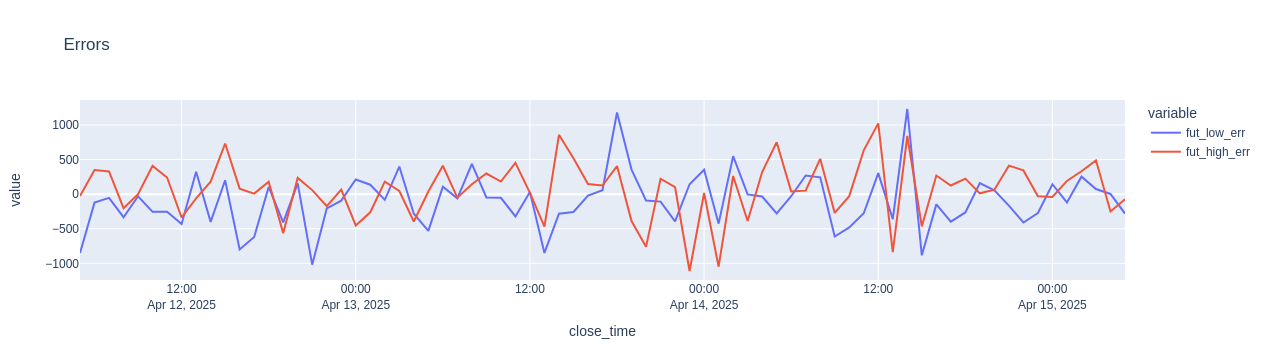

In [17]:
import plotly as py
import plotly.express as px
from plotly import graph_objects as go
# Remove plotly warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plot_y_pred_err(y_test, y_pred):
    err = pd.DataFrame()
    err['fut_low_err'] = y_pred['fut_low_diff'] - y_test['fut_low_diff']
    err['fut_high_err'] = y_pred['fut_high_diff'] - y_test['fut_high_diff']
    px.line(err, title='Errors').show()

plot_y_pred_err(y_test, y_pred)


# Evaluate the model

### Trading emulation

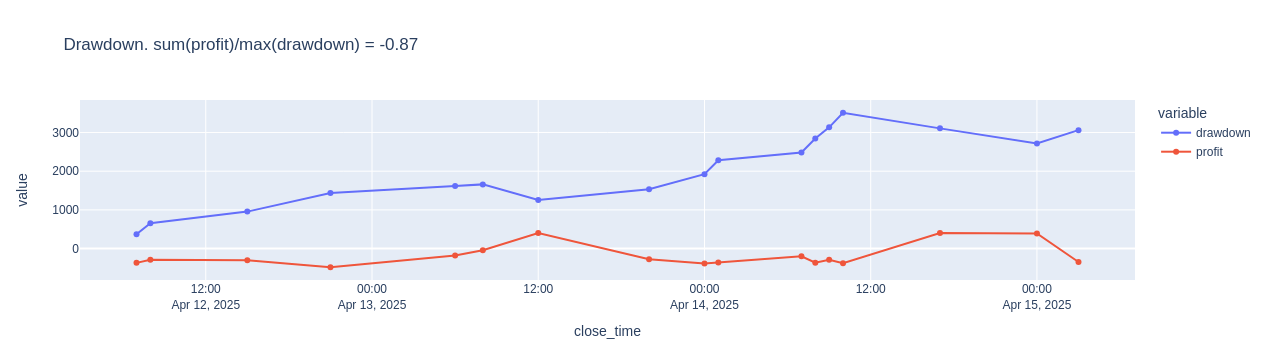

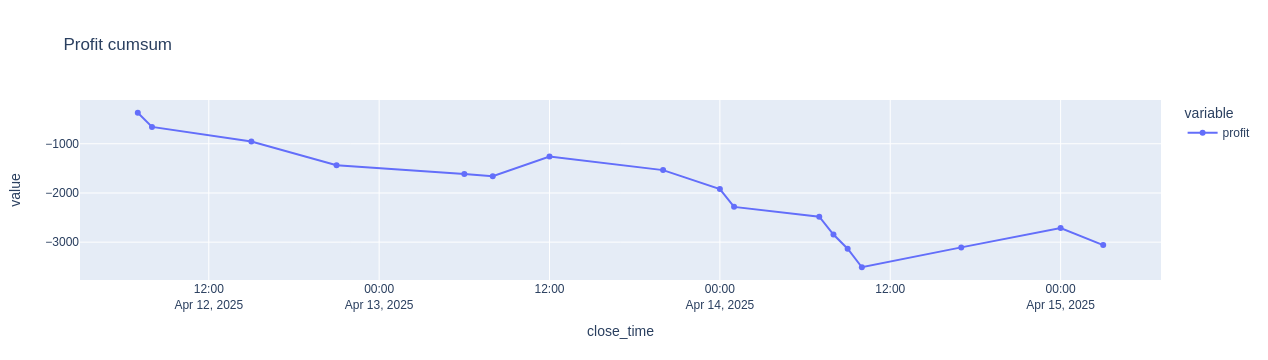

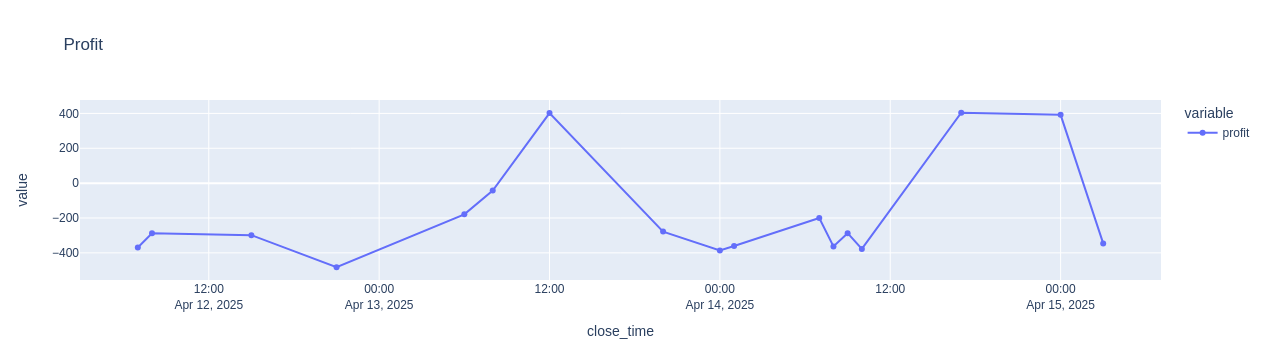

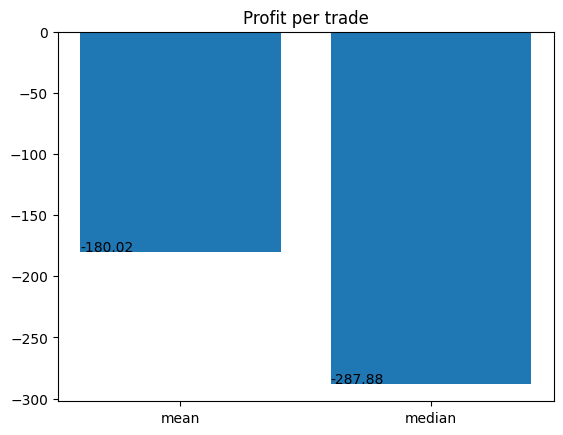

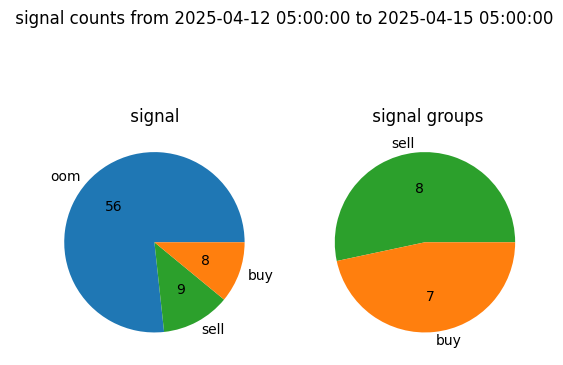

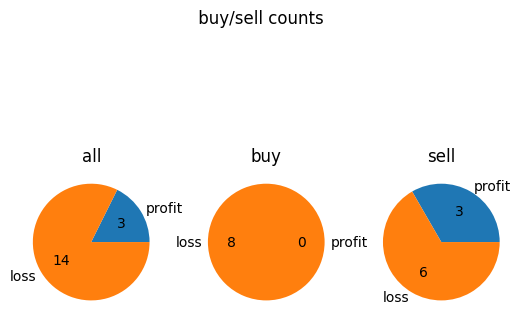

In [18]:
from pytrade2.pytrade2.strategy.signal.SignalByFutLowHigh import SignalByFutLowHigh
import seaborn as sns


def calc_signal_ext(candles_target, y_test, y_pred):
    """ Using predicted values, create dataframe with signal, stoploss, takeprofit """
    # Combine test with pred
    fut_df = pd.DataFrame(index = y_pred.index)
    fut_df['close'] = candles_target['close']
    fut_df['fut_low'] = candles_target['close'] + y_test['fut_low_diff']
    fut_df['fut_high'] = candles_target['close'] + y_test['fut_high_diff']
    fut_df['fut_low_pred'] = candles_target['close'] + y_pred['fut_low_diff']
    fut_df['fut_high_pred'] = candles_target['close'] + y_pred['fut_high_diff']

    # Signal calculator from pytrade2
    signal_calc = SignalByFutLowHigh(profit_loss_ratio=profit_loss_ratio,
                                stop_loss_min_coeff=stop_loss_min_coeff,
                                stop_loss_max_coeff=stop_loss_max_coeff,
                                stop_loss_add_ratio = stop_loss_add_ratio,
                                take_profit_min_coeff=take_profit_min_coeff,
                                take_profit_max_coeff=take_profit_max_coeff,
                                comission_pct=comission_pct,
                                price_presision=price_precision)
    
    # Create df: signal, stoploss, take profit
    signal_df = fut_df[['close', 'fut_low_pred', 'fut_high_pred']]\
            .apply(lambda row: signal_calc.calc_signal(row[0], row[1], row[2]), axis=1, result_type='expand')
    signal_df.columns = ['signal', 'sl', 'tp']    
    signal_df = pd.concat([signal_df, fut_df], axis=1)
    signal_df = with_profit(signal_df)
    signal_df = with_drawdown(signal_df)    
    return pd.concat([signal_df, fut_df], axis=1)
    
def with_profit(signal):
    """ Metric: profit it trade by predicted values """

    # Buy and price keeps above stop loss and goes over tp
    is_buy_profit = (signal['signal'] == 1) & (signal['fut_low'] > signal['sl']) & (signal['fut_high'] >= signal['tp'])
    is_buy_loss = (signal['signal'] == 1) & (~is_buy_profit)
    
    # Sell and price keeps below stop loss and goes below tp
    is_sell_profit = (signal['signal'] == -1) & (signal['fut_high'] < signal['sl']) & (signal['fut_low'] <= signal['tp'])
    is_sell_loss = (signal['signal'] == -1) & (~is_sell_profit)

    #profit = pd.DataFrame(index = signal.index)
    signal['profit'] = 0

    # Buy profit or loss
    signal.loc[is_buy_profit, 'profit'] = signal['tp'] - signal['close'] - (signal['tp']*comission) - (signal['close']*comission)
    signal.loc[is_buy_loss, 'profit'] = signal['sl'] - signal['close'] - (signal['sl']*comission) - (signal['close']*comission)

    # Sell profit or loss
    signal.loc[is_sell_profit, 'profit'] = signal['close'] - signal['tp'] - (signal['close']*comission) - (signal['tp']*comission)
    signal.loc[is_sell_loss, 'profit'] = signal['close'] - signal['sl'] - (signal['close']*comission) - (signal['sl']*comission)

    # # Buy profit or loss
    # signal.loc[is_buy_profit, 'profit'] = signal['tp'] - signal['close'] - (signal['tp']*comission) - (signal['close']*comission)
    # signal.loc[is_buy_loss, 'profit'] = signal['sl'] - signal['close'] - (signal['sl']*comission) - (signal['close']*comission)

    # # Sell profit or loss
    # signal.loc[is_sell_profit, 'profit'] = signal['close'] - signal['tp'] - (signal['close']*comission) - (signal['tp']*comission)
    # signal.loc[is_sell_loss, 'profit'] = signal['close'] - signal['sl'] - (signal['close']*comission) - (signal['sl']*comission)
    
    return signal

def with_drawdown(df):
    # todo: remove -10
    #profits = df.loc[df['profit'] != 0, 'profit'][:-10]
    profits = df['profit']
    max_drawdown = 0
    cur_drawdown = 0
    drawdowns = []
        
    for profit in profits.values:
        if profit < 0:
            # Loss - increase drawdown
            cur_drawdown -= profit # increase drawdown
        else:
            # We have profit! Decrease drowdown, or if profit covered previous drawdown, set drawdown to 0.
            cur_drawdown = max(0, cur_drawdown - profit)
        max_drawdown = max(max_drawdown, cur_drawdown)
        drawdowns.append(cur_drawdown)

    df['drawdown'] = drawdowns
    return df

def plot_drawdown(signal_ext):
    drawdown = max(signal_ext['drawdown'])
    profit = sum(signal_ext['profit'])
    ratio = round(profit/drawdown, 2) if drawdown > 0 else 'infinity'
    title = f'Drawdown. sum(profit)/max(drawdown) = {ratio}'
    px.line(signal_ext.loc[signal_ext['signal']!=0, ['drawdown', 'profit']], title = title).update_traces(mode='lines+markers').show()

def barplot_profit(signal_ext):
    profit_df = signal_ext.loc[signal_ext['profit']!=0, 'profit']
    mean = profit_df.mean()
    median = profit_df.median()
    
    bars = plt.bar(x=["mean", "median"], height=[mean, median])
    for bar in bars:
        yval = round(bar.get_height(), 2)
        plt.text(bar.get_x(), yval + .005, yval)
    
    plt.title('Profit per trade');
    plt.show()

    #sns.barplot(x=["mean", "median1"], y=[mean, median]);
    

signal_ext = calc_signal_ext(candles_by_period[target_period], y_test, y_pred)

# Drawdown plot
plot_drawdown(signal_ext)

# Profit cumsumplot
px.line(signal_ext.loc[signal_ext['signal']!=0, 'profit'].cumsum(), title = 'Profit cumsum').update_traces(mode='lines+markers').show()
px.line(signal_ext.loc[signal_ext['signal']!=0, 'profit'], title = f'Profit').update_traces(mode='lines+markers').show()
barplot_profit(signal_ext)

# Pie plots
PlotTool.plot_signal_counts(signal_ext)
PlotTool.plot_buy_sell(signal_ext)

## MLFlow experiment

In [19]:
y_test.info()
y_pred.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73 entries, 2025-04-12 05:00:00 to 2025-04-15 05:00:00
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fut_low_diff   73 non-null     float64
 1   fut_high_diff  73 non-null     float64
dtypes: float64(2)
memory usage: 3.8 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73 entries, 2025-04-12 05:00:00 to 2025-04-15 05:00:00
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fut_low_diff   73 non-null     float64
 1   fut_high_diff  73 non-null     float64
dtypes: float64(2)
memory usage: 3.8 KB


In [20]:
import mlflow
from mlflow import MlflowClient

#mlflow.set_tracking_uri('http://localhost:5000')
#mlflow_client = MlflowClient()

#mlflow.set_tracking_uri('http://localhost:5000')
#mlflow_client = MlflowClient()

def new_experiment(mflow_client, experiment_name):
    print(f'Creating new mlflow experiment {experiment_name}')
    experiment_tags = {'project_name': 'pytrade2'}
    artifact_location='s3://pytrade2/mlartifacts'
    experiment = mlflow_client.create_experiment(
        name=experiment_name, tags=experiment_tags, artifact_location=artifact_location
    )    
    return experiment

def ensure_experiment(mlflow_client, experiment_name):
    experiments = mlflow_client.search_experiments(filter_string=f"name = '{experiment_name}' AND tags.project_name='pytrade2'")
    if not experiments:
        experiment = new_experiment(mlflow_client, experiment_name)
    else:
        experiment = experiments[-1]
    return experiment


In [21]:
def calc_metrics():
    """ Metrics to use for evaluation """
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    profit_mean = signal_ext.loc[signal_ext['signal'] != 0, 'profit'].mean()
    profit_median = signal_ext.loc[signal_ext['signal'] != 0, 'profit'].median()
    profit_drawdown_ratio = sum(signal_ext['profit'])/max(signal_ext['drawdown'])

    return {
        'profit_drawdown_ratio': profit_drawdown_ratio,
        'profit_mean': profit_mean,
            'profit_median': profit_median,
            "mae": mae, 
            "mse": mse, 
            "rmse": rmse, 
            "r2": r2}

In [22]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime

if do_log_experiment:
    print('Logging experiment')
    experiment = ensure_experiment(mlflow_client, experiment_name)
    mlflow.set_experiment(experiment_name)
    
    metrics = calc_metrics()
    #print(metrics)
    #run_name = f'{experiment_name}_{datetime.now()}'
    
    params = {
        # "n_estimators": 100,
        # "max_depth": 6,
        # "min_samples_split": 10,
        # "min_samples_leaf": 4,
        # "bootstrap": True,
        # "oob_score": False,
        # "random_state": 888,
    
        'train_size_rows': len(x_train),
        'history_days': history_days,
        'test_days': test_days,
        'profit_loss_ratio':  profit_loss_ratio,
        'take_profit_min_coeff': take_profit_min_coeff,
        'stop_loss_max_coeff': stop_loss_max_coeff,
        'stop_loss_add_ratio': stop_loss_add_ratio,
        'take_profit_max_coeff': take_profit_max_coeff,
        'stop_loss_min_coeff': stop_loss_min_coeff,
        'is_trailing_stop': is_trailing_stop,
        'comission_pct': comission_pct,
        'features_candles_periods': features_candles_periods,
        'target_period': target_period
    }
    
    
    # Initiate the MLflow run context
    import inspect
    print(inspect.signature(mlflow.sklearn.log_model))
    with mlflow.start_run(run_name = run_name) as run:
        #mlflow.set_tags({'tag': 'val'})
        # Log the parameters used for the model fit
        mlflow.log_params(params)
    
        # Log the error metrics that were calculated during validation
        mlflow.log_metrics(metrics)
    
        if do_log_model:
            # Log an instance of the trained model for later use
            artifact_path = run_name
            mlflow.sklearn.log_model(
                sk_model=model, 
                input_example=x_test,
                artifact_path=artifact_path,
                registered_model_name=model_name
            )

            # Set trade ready flag
            if is_trade_ready:
                # set extra tags on the model
                model_info = mlflow_client.get_latest_versions(model_name)[0]
                print(f'Setting model {model_name} v{model_info.version} is_trade_ready={is_trade_ready}')
                mlflow_client.set_model_version_tag(
                    name=model_name,
                    version=model_info.version,
                    key='is_trade_ready',
                    value=is_trade_ready
                )            
